In [ ]:
!nvidia-smi

Sat Sep 19 14:28:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import math
import sys
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
path = '/content/gdrive/My Drive/Dacon/HAI 2.0/'

path_train = path + 'training'
path_valid = path + 'validation'
path_test = path + 'testing'
path_submission = path + 'sample_submission.csv'

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

# these change models
timelen = 50
stride = 3
Modelname = 'HAI_AE_1'

# these can be changed any time
demand_validation_ratio = 0.1
epoch = 50
batch_size = 32
verbose = 1
optim = 'adam' # tfa.optimizers.SWA(tf.keras.optimizers.SGD())

In [ ]:
def plot_history(history):
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.plot(history.history['loss'], 'r--', history.history['val_loss'], 'b--')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def get_progressbar_str(progress):
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))
    
def put_labels(submission, threshold):
    temp = np.zeros_like(submission, dtype = 'int8')
    temp[submission > threshold] = 1
    return temp

In [ ]:
def train_raw_to_val(train_list, demand_validation_ratio, C_cols):
    temp = 0
    for item in train_list:
        temp += len(item)
    demand_validation_length = int(temp * demand_validation_ratio)
    i = random.randrange(3) # target = train_list[i]
    j = random.randrange(2)
    if j == 0: # 뒤에서 추출
        val = train_list[i].iloc[-demand_validation_length:,:]
        train_list[i] = train_list[i].iloc[:len(train_list[i])-demand_validation_length,:]
    if j == 1: # 앞에서 추출
        val = train_list[i].iloc[:demand_validation_length,:]
        train_list[i] = train_list[i].iloc[demand_validation_length:,:]
        
    df = pd.DataFrame()
    for item in train_list:
        df = df.append(item, ignore_index=True)
    temp_scaler = MinMaxScaler()
    temp_scaler.fit(df[C_cols].values)
    val = temp_scaler.transform(val[C_cols].values)

    return train_list, val


def read_data(path, att = False, scaler = None, C_cols = None, demand_validation_ratio = None):
    file_paths = glob.glob(path+'/*.csv')
    res = []
    print("="*30)
    print("Attack :",att)
    if att and scaler and C_cols:
        label = None
        temp = 0
        for file in file_paths:
            f = pd.read_csv(file)
            temp += len(f)
            if 'attack' in f.columns:
                label = f['attack']
            res.append(scaler.transform(f[C_cols].values))
        print("Total test data : ", temp)
        print("List of DataFrame length : ",len(res))
        return res, label
    else:
        # df : appended dataframe to fit scaler
        df = pd.DataFrame()
        for file in file_paths:
            f=pd.read_csv(file)
            df = df.append(f, ignore_index=True)
            res.append(f)
        print("Total data length (including non-usable datas) : ",len(df))
        # make C01 ~ C79 list
        C_cols = list(df.columns)
        C_cols.remove('time')
        # makes validation data
        res, val = train_raw_to_val(res, demand_validation_ratio, C_cols)
        # make scaler
        scaler = MinMaxScaler()
        scaler.fit(df[C_cols].values)
        temp = 0
        for i, item in enumerate(res):
            res[i] = scaler.transform(item[C_cols].values)
            temp += len(res[i])
        print("Total training data (including non-usable datas) : ",temp,"  Total validation data (including non-usable datas) : ", len(val))
        print("List of DataFrame length : ",len(res))
        return res, C_cols, scaler, [val]

train_list, C_cols, scaler, val_list = read_data(path_train, demand_validation_ratio = demand_validation_ratio)
valid_list, valid_label = read_data(path_valid, att=True, scaler = scaler, C_cols = C_cols)
test_list, _ = read_data(path_test, att=True, scaler = scaler, C_cols = C_cols)
print(train_list[0].shape, val_list[0].shape, valid_list[0].shape, valid_label.shape, test_list[0].shape)

Attack : False
Total data length (including non-usable datas) :  921603
Total training data (including non-usable datas) :  829443   Total validation data (including non-usable datas) :  92160
List of DataFrame length :  3
Attack : True
Total test data :  43201
List of DataFrame length :  1
Attack : True
Total test data :  358804
List of DataFrame length :  4
(216001, 79) (92160, 79) (43201, 79) (43201,) (118801, 79)


In [ ]:
def seq2timeser(some_list,sr,st,le,ba,sh):
    res = []
    for item in some_list:
        res.append( TimeseriesGenerator(item, item, sampling_rate = sr, stride = st, length = le, batch_size=ba, shuffle = sh) )
    return res

train_list_seq = seq2timeser(train_list, 1, stride, timelen, batch_size, True)
val_list_seq = seq2timeser(val_list, 1, stride, timelen, 1000, True)
valid_list_seq = seq2timeser(valid_list, 1, 1, timelen, 1000, False)
test_list_seq = seq2timeser(test_list, 1, 1, timelen, 1000, False)

In [ ]:
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        res = target[0]
        return res, np.zeros_like(res)     # X, zeros_like(X) 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train = Train_DataLoader(train_list_seq)
val = Train_DataLoader(val_list_seq)

In [ ]:
# only for training...
def generate_and_train_model(train, epoch, batch_size, val, Modelname):  # loss 에서 대회 주어진거 사용해야할듯
    print("Starting to train ",Modelname)
    callbacks1 = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True), ReduceLROnPlateau(monitor = 'loss', patience = 6)]
    with tf.device('/device:GPU:0'):
        inp = layers.Input(shape = (timelen,79))
        mid = layers.Bidirectional(layers.LSTM(79,return_sequences=True), merge_mode='ave')(inp)
        mid = layers.Bidirectional(layers.LSTM(79,return_sequences=False), merge_mode='ave')(mid)
        mid = layers.RepeatVector(n = timelen)(mid)
        mid = layers.Bidirectional(layers.LSTM(timelen,return_sequences=True), merge_mode='ave')(mid)
        mid = layers.TimeDistributed(layers.Dense(79, activation = 'relu'))(mid)
        out = layers.subtract([inp, mid])

        model = keras.Model(inputs = inp, outputs = out)
        model.compile(optimizer=optim,loss='MSE')
        print(model.summary())
        history = model.fit(train, epochs = epoch, verbose = 1, validation_data = val, callbacks = callbacks1) #, callbacks = callbacks1
    model.save(path + Modelname + '.h5')
    print("...model saved !")
    return history

history = generate_and_train_model(train, epoch, batch_size, val, Modelname)
plot_history(history)

Starting to train  HAI_AE_1
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 50, 79)]     0                                            
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, 50, 79)       100488      input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_22 (Bidirectional (None, 79)           100488      bidirectional_21[0][0]           
__________________________________________________________________________________________________
repeat_vector_7 (RepeatVector)  (None, 50, 79)       0           bidirectional_22[0][0]           
__________________________________________________________

In [ ]:
class Test_DataLoader(keras.utils.Sequence):  # timegen 하나가 X 값만 뽑아줄 수 있도록 한다.
    def __init__(self,test_seq):
        self.test_seq = test_seq
    def __getitem__(self, i):
        return self.test_seq[i][0]
    def __len__(self):
        return len(self.test_seq)

def test_and_get_list(Modelname, some_list, some_raw_list):
    model = tf.keras.models.load_model(path + Modelname + '.h5')
    loss_list = []
    for num, (timeseq, raw) in enumerate(zip(some_list, some_raw_list)):
        res = np.zeros(timelen, dtype = 'float32')  # padding
        timeseq_X = Test_DataLoader(timeseq)
        with tf.device('/device:GPU:0'):
            predicted = model.predict(timeseq_X)
        pr = np.mean( np.mean( np.abs(predicted), axis = 2), axis = 1).astype('float32')
        res = np.concatenate((res, pr), axis=0)
        assert len(res) == len(raw)
        # loss = np.mean(np.abs(res, raw), axis = 1)
        loss_list.append(res)
    for num, loss in enumerate(loss_list):
        if num == 0:
            res = loss
        else:
            res = np.concatenate((res,loss), axis = 0)
    return res

valid_result = test_and_get_list(Modelname, valid_list_seq, valid_list)

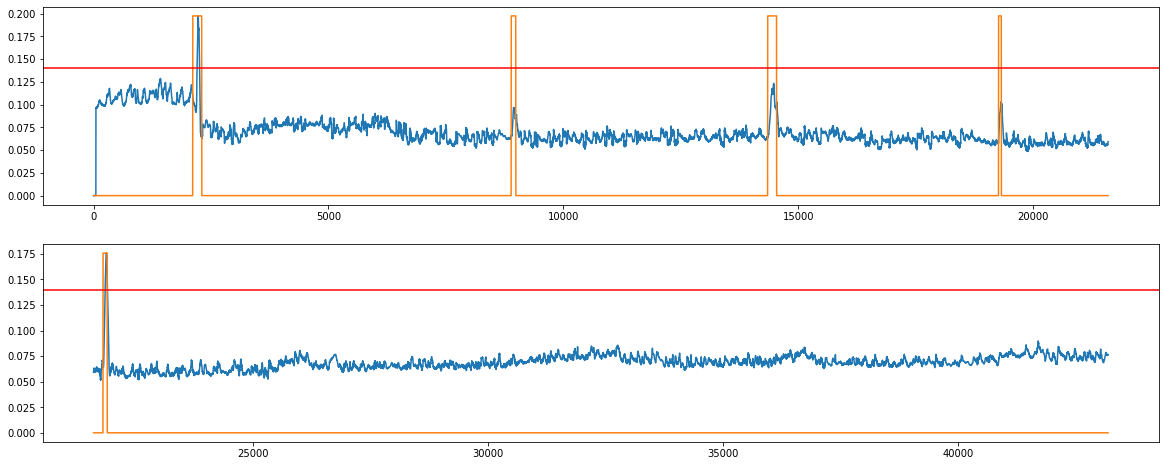

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak )
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

check_graph(valid_result, valid_label, THRESHOLD= 0.14)

In [ ]:
! pip install '/content/gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl'
from TaPR_pkg import etapr

Processing ./gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl


In [ ]:
# 먼저 어디부터 어디까지로 할지 정해야 한다.
final = put_labels(valid_result, 0.14)
TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.443 (TaP: 1.000, TaR: 0.285)
# of detected anomalies: 2
Detected anomalies: ['1', '5']


In [ ]:
res = []
ff = 0.08
ee = 0.09
NN = 1000
inc = 0
for i in range(NN):
    th = ff + i * (ee-ff)/NN
    final = put_labels(valid_result, th)
    TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
    res.append((TaPR['f1'],th))
    inc += 1
    sys.stderr.write('\r\033[K' + get_progressbar_str(inc/NN))
    sys.stderr.flush()
_, threshold = max(res)
final = put_labels(valid_result, threshold)
TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")
print("Threshold : ",threshold)

In [ ]:
test_result = test_and_get_list(Modelname, test_list_seq)

In [ ]:
def put_labels(some_result, threshold):
    temp = np.zeros_like(some_result, dtype = 'int8')
    temp[some_result > threshold] = 1
    return temp

test_label = put_labels(test_result, threshold)

In [ ]:
check_graph(test_result, test_label, THRESHOLD= 0.06)

In [ ]:
submission = pd.read_csv(path_submission)
submission['attack'] = test_label
submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'.csv',index = False)